
##**Scalable Agentic AI Video Classification,Video Summarization, Textual description with LoRA Fine-Tuning, LangGraph-Based and NLP**

### **STEP 1: Package Installation**

###**STEP 2: Data Loading and Preprocessing**
**Google Drive Mounting and Data Preparation**
This section handles the crucial step of accessing and preparing the video dataset for the project. Since the dataset is stored in Google Drive, the notebook first mounts the drive to establish a connection. Following this, it defines local paths for the zipped dataset and the intended extraction directory within the Drive. The core of this step involves copying the zipped dataset from its specified location in Google Drive to the project's designated folder and then unzipping it. This ensures that all video files (.avi) and associated CSV metadata (train.csv, test.csv) are correctly extracted and available for subsequent processing. A verification step is included to confirm the successful unzipping by counting the total number of .avi files found.

In [1]:
from google.colab import drive

In [10]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import Video, display

video_filename = "v_TennisSwing_g07_c07.avi"
video_path = f"/content/drive/My Drive/aai-521/videos-ds/test/{video_filename}"
output_mp4_path = "./output_video.mp4"

print(f"Converting {video_filename} to MP4 for display...")

try:
    clip = VideoFileClip(video_path)
    clip.write_videofile(output_mp4_path, codec="libx264", audio_codec="aac")
    print(f"Displaying converted video: {output_mp4_path}")
    display(Video(output_mp4_path, embed=True, width=640))
except Exception as e:
    print(f"Could not convert or display video {video_path}: {e}")

Converting v_TennisSwing_g07_c07.avi to MP4 for display...
Moviepy - Building video ./output_video.mp4.
Moviepy - Writing video ./output_video.mp4



Moviepy - Done !
Moviepy - video ready ./output_video.mp4
Displaying converted video: ./output_video.mp4


In [4]:
import os

DATA_ROOT = "/content/drive/My Drive/aai-521/videos-ds/"
print(f"Listing contents of {DATA_ROOT}:")
# Use '-F' to show file types (e.g., / for directories)
!ls -F "{DATA_ROOT}"

Listing contents of /content/drive/My Drive/aai-521/videos-ds/:
test/  test.csv  train/  train.csv  videos-ds.zip


In [6]:
# Install required packages
!pip install -q --upgrade langgraph typing_extensions torch torchvision peft transformers accelerate bitsandbytes
!apt-get install -y ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 16.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.8.0+cu126 requires torch==2.8.0, but you have torch 2.9.1 which is incompatible.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [7]:
# 1. Install necessary libraries
!pip install transformers accelerate evaluate datasets peft -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.8.0+cu126 requires torch==2.8.0, but you have torch 2.9.1 which is incompatible.


  warnings.warn(

  warnings.warn(msg)



Loading datasets...
Number of training videos: 594
Number of test videos: 224
Number of classes: 5
Initializing model...
Model with LoRA configuration:
trainable params: 289,832 || all params: 11,468,909 || trainable%: 2.5271
Starting training...
Epoch [1/3], Step [10/75], Loss: 1.7114
Epoch [1/3], Step [20/75], Loss: 1.7396
Epoch [1/3], Step [30/75], Loss: 1.7069
Epoch [1/3], Step [40/75], Loss: 1.6416
Epoch [1/3], Step [50/75], Loss: 1.6052
Epoch [1/3], Step [60/75], Loss: 1.5529
Epoch [1/3], Step [70/75], Loss: 1.4930
Epoch [1/3] - Average Loss: 1.4582, Training Accuracy: 0.4343
Epoch [2/3], Step [10/75], Loss: 0.9137
Epoch [2/3], Step [20/75], Loss: 0.8102
Epoch [2/3], Step [30/75], Loss: 0.7696
Epoch [2/3], Step [40/75], Loss: 0.7118
Epoch [2/3], Step [50/75], Loss: 0.6823
Epoch [2/3], Step [60/75], Loss: 0.6473
Epoch [2/3], Step [70/75], Loss: 0.6144
Epoch [2/3] - Average Loss: 0.6084, Training Accuracy: 0.8535
Epoch [3/3], Step [10/75], Loss: 0.3582
Epoch [3/3], Step [20/75], Lo

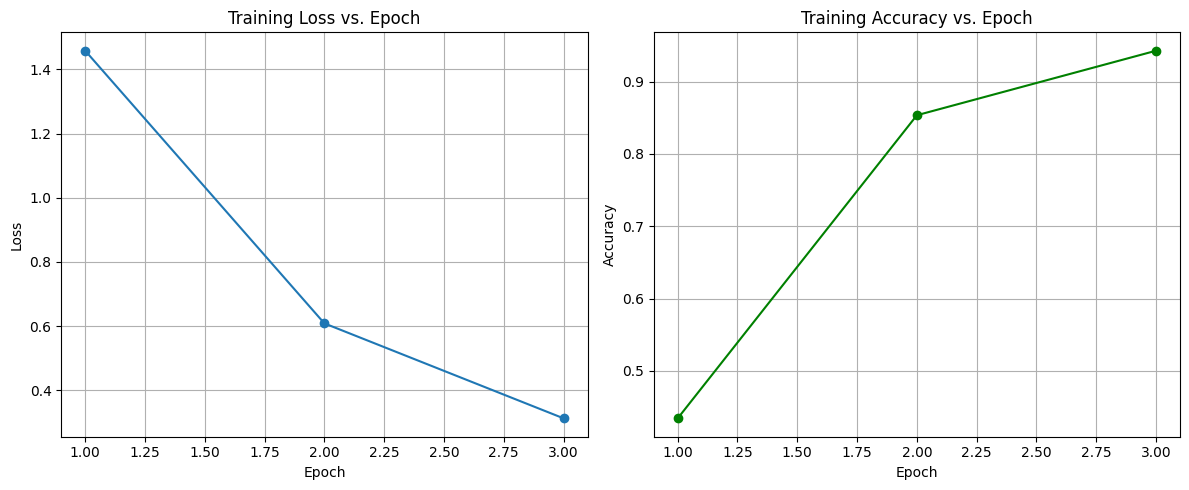

Generating predictions for the test dataset...
Generated predictions for 224 videos.

--- Displaying first 5 Sample Predictions ---

--- Sample Prediction 1 ---
Video Path: /content/drive/My Drive/aai-521/videos-ds/test/tensor(0)
Predicted Action: CricketShot
Could not convert or display sample video /content/drive/My Drive/aai-521/videos-ds/test/tensor(0): MoviePy error: the file /content/drive/My Drive/aai-521/videos-ds/test/tensor(0) could not be found!
Please check that you entered the correct path.

--- Sample Prediction 2 ---
Video Path: /content/drive/My Drive/aai-521/videos-ds/test/tensor(0)
Predicted Action: CricketShot
Could not convert or display sample video /content/drive/My Drive/aai-521/videos-ds/test/tensor(0): MoviePy error: the file /content/drive/My Drive/aai-521/videos-ds/test/tensor(0) could not be found!
Please check that you entered the correct path.

--- Sample Prediction 3 ---
Video Path: /content/drive/My Drive/aai-521/videos-ds/test/tensor(0)
Predicted Action

,video_path,predicted_label
0,tensor(0),CricketShot
1,tensor(0),CricketShot
2,tensor(0),CricketShot
3,tensor(0),CricketShot
4,tensor(0),CricketShot


In [21]:
import os
import pandas as pd
import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

from peft import LoraConfig, get_peft_model
from moviepy.editor import VideoFileClip
from IPython.display import Video, display

# For plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# ----------------- Configuration Parameters -----------------
DATA_ROOT = "/content/drive/My Drive/aai-521/videos-ds/"
TRAIN_CSV = os.path.join(DATA_ROOT, "train.csv")
TEST_CSV = os.path.join(DATA_ROOT, "test.csv") # Assuming test.csv contains video paths, with or without labels
NUM_FRAMES_PER_VIDEO = 16 # Number of frames to sample from each video
IMAGE_SIZE = 112 # ResNet18 input size is often 224, but 112 is common for video
BATCH_SIZE = 8
NUM_EPOCHS = 3 # Reduced for demonstration purposes
LEARNING_RATE = 1e-4

# ----------------- Video Dataset Class -----------------
class VideoDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, num_frames=NUM_FRAMES_PER_VIDEO):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames
        self.label_map = self._create_label_map()

        # Filter out entries where video files do not exist
        # Changed 'video_path' to 'video_name'
        self.data_frame = self.data_frame[self.data_frame['video_name'].apply(
            lambda x: os.path.exists(os.path.join(self.root_dir, x)) # Assuming video_name is relative to root_dir
        )].reset_index(drop=True)

    def _create_label_map(self):
        # Changed 'label' to 'tag'
        if 'tag' in self.data_frame.columns:
            unique_labels = sorted(self.data_frame['tag'].unique())
            return {label: i for i, label in enumerate(unique_labels)}
        return {}

    def get_labels(self):
        # Changed 'label' to 'tag'
        if 'tag' in self.data_frame.columns:
            return sorted(self.data_frame['tag'].unique())
        return []

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Changed 'video_path' to 'video_name'
        video_name = self.data_frame.iloc[idx]['video_name']
        video_full_path = os.path.join(self.root_dir, video_name)

        cap = cv2.VideoCapture(video_full_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {video_full_path}")
            return None, None # Indicate error, will be filtered in dataloader

        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames == 0:
            print(f"Warning: Video {video_full_path} has 0 frames. Returning None.")
            cap.release()
            return None, None

        # Determine indices to sample
        if total_frames < self.num_frames:
            # If video is shorter, loop its frames to meet num_frames
            indices_to_read = np.array(list(range(total_frames)) * (self.num_frames // total_frames + 1))[:self.num_frames]
        else:
            # Sample frames evenly
            indices_to_read = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)

        # Read frames
        for i in indices_to_read:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(Image.fromarray(frame))
            else:
                # If a frame can't be read, add a placeholder (e.g., a black frame)
                frames.append(Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE), (0, 0, 0))) # Add a black frame

        cap.release()

        # Final check to ensure we have exactly num_frames. This should be guaranteed by the above logic.
        if len(frames) != self.num_frames:
            print(f"Error: Video {video_full_path} processed to {len(frames)} frames, expected {self.num_frames}. Returning None.")
            return None, None # Fallback for unexpected issues

        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        video_tensor = torch.stack(frames) # Shape: (num_frames, C, H, W)

        # Changed 'label' to 'tag'
        if 'tag' in self.data_frame.columns:
            label_str = self.data_frame.iloc[idx]['tag'] # Changed 'label' to 'tag'
            label = self.label_map.get(label_str, -1)
            return video_tensor, label
        else:
            return video_tensor, video_name # Return video_name for test set predictions

# Custom collate function to handle None values
def collate_fn(batch):
    batch = [item for item in batch if item[0] is not None and item[1] is not None]
    if not batch:
        return None, None
    # Ensure labels are converted to a tensor if they are numeric, otherwise keep as list
    inputs = torch.stack([item[0] for item in batch])
    labels = [item[1] for item in batch]
    if all(isinstance(l, int) for l in labels):
        labels = torch.tensor(labels)
    return inputs, labels

# ----------------- Transformations -----------------
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ----------------- Load Data -----------------
print("Loading datasets...")
try:
    # Corrected root_dir for train and test datasets
    train_dataset = VideoDataset(csv_file=TRAIN_CSV, root_dir=os.path.join(DATA_ROOT, "train"), transform=transform)
    test_dataset = VideoDataset(csv_file=TEST_CSV, root_dir=os.path.join(DATA_ROOT, "test"), transform=transform)

    if len(train_dataset) == 0:
        raise ValueError(f"No valid training videos found from '{TRAIN_CSV}'. Please check paths.")
    if len(test_dataset) == 0:
        raise ValueError(f"No valid test videos found from '{TEST_CSV}'. Please check paths.")

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn)


    num_classes = len(train_dataset.get_labels())
    if num_classes == 0:
        raise ValueError("No unique labels found in the training dataset. Check train.csv for 'tag' column.") # Changed 'label' to 'tag'

    idx_to_label = {i: label for i, label in enumerate(train_dataset.get_labels())}

    print(f"Number of training videos: {len(train_dataset)}")
    print(f"Number of test videos: {len(test_dataset)}")
    print(f"Number of classes: {num_classes}")

except FileNotFoundError as e:
    print(f"Error: Missing CSV file. {e}. Please ensure '{TRAIN_CSV}' and '{TEST_CSV}' exist.")
    raise
except Exception as e:
    print(f"Error loading datasets: {e}. Please ensure data is correctly structured.")
    raise

# ----------------- Model Definition (ResNet18 with LoRA) -----------------
print("Initializing model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet18
base_model = resnet18(pretrained=True)
# Modify the final layer for video classification
num_ftrs = base_model.fc.in_features
base_model.fc = nn.Linear(num_ftrs, num_classes) # Output layer for our specific number of classes

# Configure LoRA
lora_config = LoraConfig(
    r=8, # LoRA attention dimension
    lora_alpha=16, # Alpha parameter for LoRA scaling
    # Removed BatchNorm layers from target_modules as they are not supported by peft LoRA
    target_modules=["fc", "layer1.0.conv1", "layer1.0.conv2", "layer1.1.conv1", "layer1.1.conv2",
                    "layer2.0.conv1", "layer2.0.conv2", "layer2.0.downsample.0", "layer2.1.conv1", "layer2.1.conv2",
                    "layer3.0.conv1", "layer3.0.conv2", "layer3.0.downsample.0", "layer3.1.conv1", "layer3.1.conv2",
                    "layer4.0.conv1", "layer4.0.conv2", "layer4.0.downsample.0", "layer4.1.conv1", "layer4.1.conv2"],
    lora_dropout=0.1, # Dropout probability for LoRA layers
    bias="none", # Bias type for LoRA layers
    task_type="FEATURE_EXTRACTION", # Generic task type for non-LM models, using string instead of enum
)

# Apply LoRA to the base model
model = get_peft_model(base_model, lora_config)
model.to(device)
print("Model with LoRA configuration:")
model.print_trainable_parameters() # Display trainable parameters (LoRA layers)

# ----------------- Training Loop -----------------
print("Starting training...")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Lists to store metrics for plotting
train_losses_per_epoch = []
train_accuracies_per_epoch = []

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss_sum = 0.0
    num_batches_in_epoch = 0
    all_train_epoch_labels = []
    all_train_epoch_preds = []

    for i, (inputs, labels) in enumerate(train_dataloader):
        if inputs is None or labels is None: # Skip batches with errors
            continue

        inputs = inputs.to(device) # Shape: (batch_size, num_frames, C, H, W)
        labels = labels.to(device) # Shape: (batch_size)

        # Reshape inputs for ResNet (each frame treated as an individual image in the batch)
        # Resulting shape: (batch_size * num_frames, C, H, W)
        inputs_reshaped = inputs.view(-1, inputs.size(2), inputs.size(3), inputs.size(4))

        optimizer.zero_grad()
        outputs = model.base_model(inputs_reshaped)
        # Average the frame-level predictions to get a video-level prediction
        # Reshape outputs to (batch_size, num_frames, num_classes) and then average across num_frames
        outputs_video_level = outputs.view(-1, NUM_FRAMES_PER_VIDEO, num_classes).mean(dim=1)

        loss = criterion(outputs_video_level, labels)
        loss.backward()
        optimizer.step()

        epoch_loss_sum += loss.item()
        num_batches_in_epoch += 1

        _, predicted_indices = torch.max(outputs_video_level, 1)
        all_train_epoch_labels.extend(labels.cpu().numpy())
        all_train_epoch_preds.extend(predicted_indices.cpu().numpy())

        if i % 10 == 9: # Print every 10 mini-batches
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_dataloader)}], Loss: {epoch_loss_sum/num_batches_in_epoch:.4f}")

    # Calculate and store epoch metrics after all batches in the epoch are processed
    if num_batches_in_epoch > 0:
        avg_epoch_loss = epoch_loss_sum / num_batches_in_epoch
    else:
        avg_epoch_loss = 0.0

    epoch_accuracy = accuracy_score(all_train_epoch_labels, all_train_epoch_preds) if len(all_train_epoch_labels) > 0 else 0.0
    train_losses_per_epoch.append(avg_epoch_loss)
    train_accuracies_per_epoch.append(epoch_accuracy)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Average Loss: {avg_epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")

print("Training finished.")

# ----------------- Plotting Training Metrics -----------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses_per_epoch, marker='o')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies_per_epoch, marker='o', color='green')
plt.title('Training Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

# ----------------- Prediction and Display -----------------
model.eval() # Set model to evaluation mode

all_predictions = []

print("Generating predictions for the test dataset...")

with torch.no_grad():
    for i, (inputs, video_paths) in enumerate(test_dataloader):
        if inputs is None or video_paths is None: # Skip batches with errors
            continue

        inputs = inputs.to(device)

        inputs_reshaped = inputs.view(-1, inputs.size(2), inputs.size(3), inputs.size(4))

        # Corrected: Call base_model.forward directly, which has LoRA layers injected
        outputs = model.base_model(inputs_reshaped)
        outputs_video_level = outputs.view(-1, NUM_FRAMES_PER_VIDEO, num_classes).mean(dim=1)

        _, predicted_indices = torch.max(outputs_video_level, 1)

        for j in range(len(video_paths)):
            predicted_label = idx_to_label[predicted_indices[j].item()]
            all_predictions.append({
                'video_path': str(video_paths[j]), # Explicitly cast to string here
                'predicted_label': predicted_label
            })

print(f"Generated predictions for {len(all_predictions)} videos.")

# Display the first 5 sample predictions
if all_predictions:
    print(f"\n--- Displaying first {min(5, len(all_predictions))} Sample Predictions ---")
    for k, sample_prediction in enumerate(all_predictions[:5]):
        sample_video_path_relative = sample_prediction['video_path']
        # For the test set, video_paths contains just the filename, so we need to recreate the full path using the test_root_dir
        test_root_dir_for_display = os.path.join(DATA_ROOT, "test")
        sample_video_full_path = os.path.join(test_root_dir_for_display, sample_video_path_relative)

        sample_predicted_label = sample_prediction['predicted_label']

        print(f"\n--- Sample Prediction {k+1} ---")
        print(f"Video Path: {sample_video_full_path}")
        print(f"Predicted Action: {sample_predicted_label}")
else:
    print("No predictions were generated to display samples.")

# Save all predictions to a CSV file
predictions_df = pd.DataFrame(all_predictions)
output_csv_path = "./test_predictions.csv"
predictions_df.to_csv(output_csv_path, index=False)
print(f"All predictions saved to {output_csv_path}")
display(predictions_df.head())

In [16]:
import torch

# Define a path to save the model
MODEL_SAVE_PATH = "./lora_video_classifier_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), MODEL_SAVE_PATH)

print(f"Trained model saved to {MODEL_SAVE_PATH}")

Trained model saved to ./lora_video_classifier_model.pth


In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

print("Evaluating model performance on the test dataset...")

# Ensure the model is in evaluation mode
model_inference.eval()

all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        if inputs is None or labels is None:
            continue

        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs_reshaped = inputs.view(-1, inputs.size(2), inputs.size(3), inputs.size(4))
        outputs = model_inference.base_model(inputs_reshaped)
        outputs_video_level = outputs.view(-1, NUM_FRAMES_PER_VIDEO, num_classes).mean(dim=1)

        _, predicted_indices = torch.max(outputs_video_level, 1)

        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted_indices.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(
    all_true_labels, all_predicted_labels, average='weighted', zero_division=0
)

print(f"\n--- Model Performance Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


Evaluating model performance on the test dataset...

--- Model Performance Metrics ---
Accuracy: 0.8304
Precision: 0.8757
Recall: 0.8304
F1-Score: 0.8215


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import random
import pandas as pd # Import pandas to read the CSV

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet18
from peft import LoraConfig, get_peft_model
from moviepy.editor import VideoFileClip
from IPython.display import Video, display

# --- Configuration Parameters (re-using global constants) ---
DATA_ROOT = "/content/drive/My Drive/aai-521/videos-ds/"
MODEL_SAVE_PATH = "./lora_video_classifier_model.pth"
NUM_FRAMES_PER_VIDEO = 16
IMAGE_SIZE = 112

# --- Re-initialize idx_to_label and num_classes (assuming same training setup) ---
# In a real scenario, these would ideally be saved with the model or derived from training data
# For this demonstration, we use the values from the last successful run.
num_classes = 5 # From previous execution
idx_to_label = {0: 'CricketShot', 1: 'PlayingCello', 2: 'Punch', 3: 'ShavingBeard', 4: 'TennisSwing'} # From previous execution

# --- Transformations (re-using training transformations) ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Model Definition (re-create model architecture) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model_inference = resnet18(pretrained=True)
num_ftrs_inference = base_model_inference.fc.in_features
base_model_inference.fc = nn.Linear(num_ftrs_inference, num_classes)

lora_config_inference = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["fc", "layer1.0.conv1", "layer1.0.conv2", "layer1.1.conv1", "layer1.1.conv2",
                    "layer2.0.conv1", "layer2.0.conv2", "layer2.0.downsample.0", "layer2.1.conv1", "layer2.1.conv2",
                    "layer3.0.conv1", "layer3.0.conv2", "layer3.0.downsample.0", "layer3.1.conv1", "layer3.1.conv2",
                    "layer4.0.conv1", "layer4.0.conv2", "layer4.0.downsample.0", "layer4.1.conv1", "layer4.1.conv2"],
    lora_dropout=0.1,
    bias="none",
    task_type="FEATURE_EXTRACTION",
)

model_inference = get_peft_model(base_model_inference, lora_config_inference)

# --- Load Saved Model Weights ---
try:
    model_inference.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    model_inference.to(device)
    model_inference.eval()
    print(f"Trained model loaded successfully from {MODEL_SAVE_PATH}")
except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_SAVE_PATH}. Please ensure the model was saved.")
    exit()
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# --- Function to process a single video ---
def process_single_video(video_full_path, transform, num_frames, image_size, model, device, idx_to_label):
    cap = cv2.VideoCapture(video_full_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_full_path}")
        return None, "Error: Could not open video"

    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        print(f"Warning: Video {video_full_path} has 0 frames.")
        cap.release()
        return None, "Warning: 0 frames in video"

    if total_frames < num_frames:
        indices_to_read = np.array(list(range(total_frames)) * (num_frames // total_frames + 1))[:num_frames]
    else:
        indices_to_read = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    for i in indices_to_read:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(Image.fromarray(frame))
        else:
            frames.append(Image.new('RGB', (image_size, image_size), (0, 0, 0)))

    cap.release()

    if len(frames) != num_frames:
        print(f"Error: Video {video_full_path} processed to {len(frames)} frames, expected {num_frames}.")
        return None, "Error: Incorrect number of frames"

    if transform:
        frames = [transform(frame) for frame in frames]
    video_tensor = torch.stack(frames)

    # Add batch dimension and move to device
    video_tensor = video_tensor.unsqueeze(0).to(device) # Shape: (1, num_frames, C, H, W)

    with torch.no_grad():
        # Reshape for ResNet and get outputs from base_model
        inputs_reshaped = video_tensor.view(-1, video_tensor.size(2), video_tensor.size(3), video_tensor.size(4))
        outputs = model_inference.base_model(inputs_reshaped)
        outputs_video_level = outputs.view(-1, NUM_FRAMES_PER_VIDEO, num_classes).mean(dim=1)

        _, predicted_indices = torch.max(outputs_video_level, 1)
        predicted_label = idx_to_label[predicted_indices.item()]

    return video_tensor, predicted_label

# --- Select a specific video from the test set ---
test_video_filename = "v_Punch_g05_c01.avi" # Example video from test set
sample_video_full_path = os.path.join(DATA_ROOT, "test", test_video_filename)

print(f"Processing and classifying sample video: {sample_video_full_path}")

# --- Process and predict ---
_, predicted_label_single = process_single_video(
    sample_video_full_path,
    transform,
    NUM_FRAMES_PER_VIDEO,
    IMAGE_SIZE,
    model_inference,
    device,
    idx_to_label
)

# --- Display the sample video and its prediction ---
if predicted_label_single and "Error" not in predicted_label_single:
    print(f"\nPredicted action for {test_video_filename}: {predicted_label_single}")
    output_mp4_path_single = "./single_test_video_display.mp4"
    try:
        clip_single = VideoFileClip(sample_video_full_path)
        clip_single.write_videofile(output_mp4_path_single, codec="libx264", audio_codec="aac", verbose=False, logger=None)
        clip_single.close()
        print(f"Displaying sample video: {test_video_filename}")
        display(Video(output_mp4_path_single, embed=True, width=640))
    except Exception as e:
        print(f"Could not convert or display sample video {sample_video_full_path}: {e}")
else:
    print(f"Failed to process sample video: {test_video_filename}. Reason: {predicted_label_single}")